### Flat Forward Interpolation

**Summary:** This program is dedicated to estimating a yield curve using the flat forward interpolation method, given the future rates or bond rates for tradeable maturities.


**Flat Forward Interpolation:** This interpolation method aims to estimate the yields between two vertices so that the forward rate between those vertices is constant at every point.

#### Necessary modules:

In [118]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

#### DI Futures Data:

In [77]:
data = pd.read_excel("DI_FUTURES_BZ.xlsx")
data["MATURITY"] = pd.to_datetime(data['MATURITY'], format='%d%b%Y:%H:%M:%S.%f')
data.tail(10)

,MATURITY,CODE,DI_FUTURES_BZ
28,2026-04-01,DI1J26,0.0829
29,2026-07-01,DI1N26,0.0838
30,2027-01-04,DI1F27,0.0852
31,2028-01-03,DI1F28,0.0877
32,2029-01-02,DI1F29,0.0889
33,2030-01-02,DI1F30,0.0902
34,2031-01-02,DI1F31,0.0912
35,2033-01-03,DI1F33,0.0929
36,2035-01-02,DI1F35,0.0943
37,2036-01-02,DI1F36,0.0948


#### Number of business days:

In [78]:
today = dt.date(2021,5,28)
data["DU"] = data["MATURITY"].apply(lambda x:np.busday_count(today.strftime("%Y-%m-%d"), x.strftime("%Y-%m-%d"))).add(1)
data.head(10)

,MATURITY,CODE,DI_FUTURES_BZ,DU
0,2021-05-28,DI1 Atual,0.0340,1
1,2021-06-01,DI1M21,0.0341,3
2,2021-07-01,DI1N21,0.0373,25
3,2021-08-02,DI1Q21,0.0395,47
4,2021-09-01,DI1U21,0.0419,69
5,2021-10-01,DI1V21,0.0439,91
6,2021-11-01,DI1X21,0.0460,112
7,2021-12-01,DI1Z21,0.0481,134
8,2022-01-03,DI1F22,0.0500,157
9,2022-02-01,DI1G22,0.0520,178


#### Forward Rates:

In [82]:
compound_rates = (data["DI_FUTURES_BZ"].add(1)**(1/252))**data["DU"]
data["FWD Rates"] = ((compound_rates/compound_rates.shift(1))**(252/(data["DU"]-data["DU"].shift(1).fillna(0)))).add(-1)
data["FWD Rates"] = data["FWD Rates"].fillna(0) + (data["FWD Rates"].isna()*1)*data["DI_FUTURES_BZ"]
data.head(10)

,MATURITY,CODE,DI_FUTURES_BZ,DU,FWD Rates
0,2021-05-28,DI1 Atual,0.0340,1,0.034000
1,2021-06-01,DI1M21,0.0341,3,0.034150
2,2021-07-01,DI1N21,0.0373,25,0.037737
3,2021-08-02,DI1Q21,0.0395,47,0.042006
4,2021-09-01,DI1U21,0.0419,69,0.047046
5,2021-10-01,DI1V21,0.0439,91,0.050198
6,2021-11-01,DI1X21,0.0460,112,0.055149
7,2021-12-01,DI1Z21,0.0481,134,0.058856
8,2022-01-03,DI1F22,0.0500,157,0.061138
9,2022-02-01,DI1G22,0.0520,178,0.067074


#### Flat Forward Interpolation:

In [113]:
last_du = data["DU"].iloc[-1]
first_du = data["DU"].iloc[0]
data_flat_fwd = pd.DataFrame(index=list(range(first_du,last_du+1)),data=list(range(first_du,last_du+1)),columns=["DU"])
data_flat_fwd = data_flat_fwd.join(data[["DI_FUTURES_BZ","FWD Rates"]].set_index(data["DU"])).fillna(method="bfill")
data_flat_fwd

,DU,DI_FUTURES_BZ,FWD Rates
1,1,0.0340,0.034000
2,2,0.0341,0.034150
3,3,0.0341,0.034150
4,4,0.0373,0.037737
5,5,0.0373,0.037737
...,...,...,...
3805,3805,0.0948,0.101620
3806,3806,0.0948,0.101620
3807,3807,0.0948,0.101620
3808,3808,0.0948,0.101620


In [139]:
du_exceptions = np.array(data["DU"])
flat_forward_array = np.array(data_flat_fwd)
yield_curve = []

c = 0
for row in flat_forward_array:
    if row[0] in du_exceptions:
        yield_curve.append(row[1])
    else:
        fwd = row[2]
        tx = yield_curve[c-1]
        d = row[0]
        yield_curve.append(((1+fwd)*(1+tx)**(d-1))**(1/d)-1)
        
data_flat_fwd["ETTJ"] = yield_curve
data_flat_fwd.head(10)

,DU,DI_FUTURES_BZ,FWD Rates,ETTJ
1,1,0.0340,0.034000,0.034000
2,2,0.0341,0.034150,0.034075
3,3,0.0341,0.034150,0.034100
4,4,0.0373,0.037737,0.035008
5,5,0.0373,0.037737,0.035553
6,6,0.0373,0.037737,0.035917
7,7,0.0373,0.037737,0.036177
8,8,0.0373,0.037737,0.036372
9,9,0.0373,0.037737,0.036523
10,10,0.0373,0.037737,0.036645


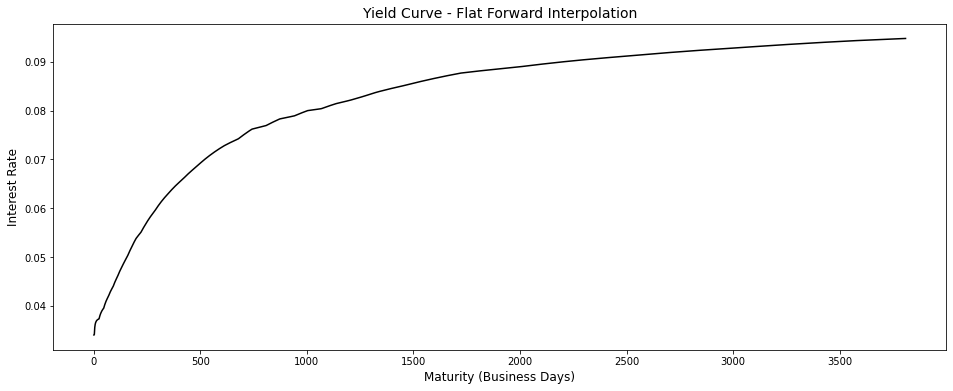

In [138]:
data_flat_fwd["ETTJ"].plot(figsize=(16,6),c="black")
plt.title("Yield Curve - Flat Forward Interpolation",size=14)
plt.xlabel("Maturity (Business Days)",size=12)
plt.ylabel("Interest Rate",size=12);